# 实验一 构建用于60×60SAR图像分类的全卷积网络    模型如下图所示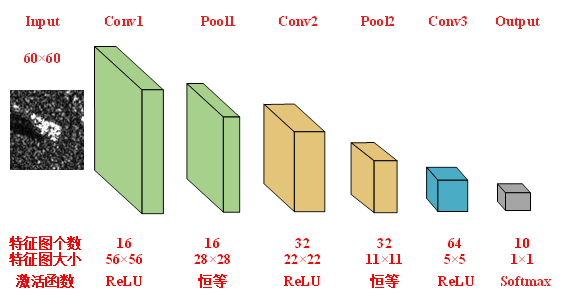

In [2]:
import numpy as np
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim

%matplotlib inline

## 从文件读取numpy数据并转为tensor格式

In [3]:
data60=scipy.io.loadmat('mstar_data/60_60.mat')
train_data=data60['train_data']
train_label=data60['train_labels']
test_data=data60['test_data']
test_label=data60['test_labels']
print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)
train_data=train_data.reshape(3671,1,60,60)
test_data =test_data.reshape(3203,1,60,60)
print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)
train_data, train_label, test_data, test_label = map(torch.tensor, (train_data,train_label.squeeze(),test_data,test_label.squeeze()))
print(train_data.shape,train_label.shape,test_data.shape,test_label.shape)

(3671, 60, 60) (1, 3671) (3203, 60, 60) (1, 3203)
(3671, 1, 60, 60) (1, 3671) (3203, 1, 60, 60) (1, 3203)
torch.Size([3671, 1, 60, 60]) torch.Size([3671]) torch.Size([3203, 1, 60, 60]) torch.Size([3203])


## 数据集标准化 

In [4]:
mean=train_data.mean()
std=train_data.std()
print(mean,std)
train_data=(train_data-mean)/std
test_data=(test_data-mean)/std
print(train_data.mean(),train_data.std(),test_data.mean(),test_data.std())

tensor(0.0727, dtype=torch.float64) tensor(0.1475, dtype=torch.float64)
tensor(3.5236e-17, dtype=torch.float64) tensor(1.0000, dtype=torch.float64) tensor(-0.0328, dtype=torch.float64) tensor(0.9620, dtype=torch.float64)


## 定义绘图函数和曲线函数

In [5]:
def plot_curve(data,name,leg):
    fig=plt.figure()
    plt.plot(range(len(data)),data,'blue')
    plt.legend([leg],fontsize=14,loc='best')
    plt.xlabel('Epoch',fontsize=14)
    plt.ylabel(name,fontsize=14)
    plt.grid()
    plt.savefig('fig'+leg)
    plt.show()

def plot_image(img,label,img_name,clas):
    fig=plt.figure()
    for i in range(10):
        plt.subplot(2,5,i+1)
        #plt.tight_layout()
        plt.imshow(img[i].view(60,60),cmap='gray')
        plt.title("{}:{}".format(img_name,label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.savefig('fig'+clas)
    plt.show()           

In [6]:
train_data09=[]
train_label09=[]
for i in range(10):
    train_data09.append(train_data[train_label==i][0])
    train_label09.append(torch.tensor(i))
print(len(train_data09),train_label09)

10 [tensor(0), tensor(1), tensor(2), tensor(3), tensor(4), tensor(5), tensor(6), tensor(7), tensor(8), tensor(9)]


## 训练集10种样本可视化

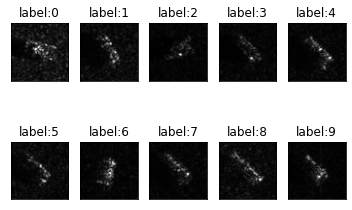

In [7]:
plot_image(train_data09,train_label09,'label','60_60')

## 加载数据集

In [8]:
bs=64
train_xy=TensorDataset(train_data,train_label)
test_xy=TensorDataset(test_data,test_label)

train = DataLoader(train_xy, batch_size=bs,shuffle=True) 
test=DataLoader(test_xy,batch_size=256) 
print(len(train_xy),len(train),len(test_xy),len(test))

3671 58 3203 13


## 搭建全卷积网络

In [9]:
class Convnet(nn.Module):

    def __init__(self):
        super(Convnet, self).__init__()
        self.for_ward=nn.Sequential(
        
        nn.Conv2d(1,16,5),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Conv2d(16,32,7),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        
        nn.Dropout2d(p=0.5), 
        nn.Conv2d(32,64,5),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        
        nn.Dropout2d(p=0.3),
        nn.Conv2d(64,10,7),
        nn.BatchNorm2d(10),
        )
    def forward(self, x):
        
        x = self.for_ward(x)
        x = x.view(x.shape[0],-1)
        x = F.softmax(x,1)
        return x


In [10]:
def forward_hook0(module, inp, outp):
    fmap_block0['input'] = inp
    fmap_block0['output'] = outp
def forward_hook1(module, inp, outp):
    fmap_block1['input'] = inp
    fmap_block1['output'] = outp
def forward_hook2(module, inp, outp):
    fmap_block2['input'] = inp
    fmap_block2['output'] = outp

## 利用GPU训练网络

In [11]:
device=torch.device('cuda:0')
model=Convnet()
model=model.to(device)

In [12]:
criterion=nn.CrossEntropyLoss(reduction='mean').to(device)
optimizer = optim.SGD(model.parameters(),lr=0.02,momentum=0.9)

In [13]:
print(model)
train_acc = []
train_loss = []
test_acc = []
test_loss=[]

Convnet(
  (for_ward): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.5, inplace=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout2d(p=0.3, inplace=False)
    (13): Conv2d(64, 10, kernel_size=(7, 7), stride=(1, 1))
    (14): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [14]:
for epoch in range(100):
    running_loss=0.0
    t_loss=0.0
    train_sum=0
    train_cor=0
    sumtest=0
    cortest=0
    model.train()
    for batch_idx,data in enumerate(train,0):
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs.float())
        loss=criterion(outputs,labels.long())
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        #train accuracy
        _,pred=torch.max(outputs.data,1)
        train_cor+=(pred==labels).sum().item()
        train_sum+=pred.shape[0]
    
    model.eval()
    for batch_idx1,data in enumerate(test,0):
        
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs.float())
        te_loss=criterion(outputs,labels.long())
        t_loss+=te_loss.item()

        _,tpred=torch.max(outputs.data,1)
        sumtest+=tpred.shape[0]
        cortest+=(tpred==labels).sum().item()
        
    print('Epoch:%d,Train loss :%.3f   Test loss :%.3f train accuracy:%.3f test accuracy:%.3f ' %(epoch+1,running_loss/batch_idx,t_loss/batch_idx1,100*train_cor/train_sum,100*cortest/sumtest))
    train_loss.append(running_loss/batch_idx)
    train_acc.append(100*train_cor/train_sum)
    test_acc.append(100*cortest/sumtest)
    test_loss.append(t_loss/batch_idx1)

Epoch:1,Train loss :2.260   Test loss :2.341 train accuracy:31.953 test accuracy:43.928 
Epoch:2,Train loss :2.137   Test loss :2.203 train accuracy:50.286 test accuracy:58.383 
Epoch:3,Train loss :2.026   Test loss :2.118 train accuracy:62.708 test accuracy:66.687 
Epoch:4,Train loss :1.940   Test loss :2.036 train accuracy:69.436 test accuracy:71.683 
Epoch:5,Train loss :1.863   Test loss :1.940 train accuracy:76.382 test accuracy:78.739 
Epoch:6,Train loss :1.804   Test loss :1.862 train accuracy:81.667 test accuracy:84.827 
Epoch:7,Train loss :1.761   Test loss :1.819 train accuracy:84.882 test accuracy:88.355 
Epoch:8,Train loss :1.709   Test loss :1.810 train accuracy:89.349 test accuracy:89.166 
Epoch:9,Train loss :1.684   Test loss :1.761 train accuracy:90.084 test accuracy:92.975 
Epoch:10,Train loss :1.651   Test loss :1.738 train accuracy:92.890 test accuracy:93.350 
Epoch:11,Train loss :1.631   Test loss :1.721 train accuracy:94.198 test accuracy:93.600 
Epoch:12,Train loss

Epoch:93,Train loss :1.498   Test loss :1.626 train accuracy:99.809 test accuracy:96.940 
Epoch:94,Train loss :1.498   Test loss :1.626 train accuracy:99.700 test accuracy:96.909 
Epoch:95,Train loss :1.500   Test loss :1.623 train accuracy:99.700 test accuracy:97.128 
Epoch:96,Train loss :1.499   Test loss :1.627 train accuracy:99.673 test accuracy:96.691 
Epoch:97,Train loss :1.496   Test loss :1.625 train accuracy:99.864 test accuracy:97.034 
Epoch:98,Train loss :1.497   Test loss :1.628 train accuracy:99.700 test accuracy:96.722 
Epoch:99,Train loss :1.498   Test loss :1.627 train accuracy:99.782 test accuracy:96.878 
Epoch:100,Train loss :1.497   Test loss :1.624 train accuracy:99.864 test accuracy:97.190 


## 绘制训练集和测试集loss和accuracy曲线

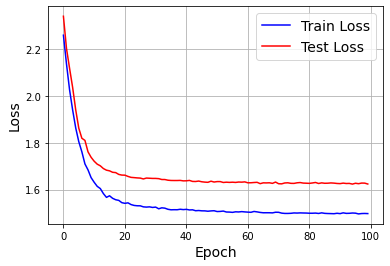

In [15]:
fig=plt.figure()
plt.plot(range(len(train_loss)),train_loss,'blue')
plt.plot(range(len(test_loss)),test_loss,'red')
plt.legend(['Train Loss','Test Loss'],fontsize=14,loc='best')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.grid()
plt.savefig('figLOSS')
plt.show()

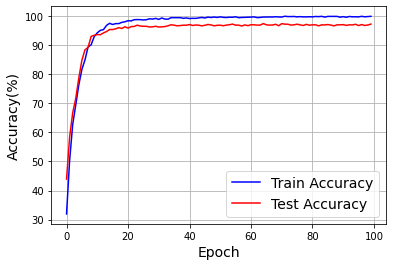

In [16]:
fig=plt.figure()
plt.plot(range(len(train_acc)),train_acc,'blue')
plt.plot(range(len(test_acc)),test_acc,'red')
plt.legend(['Train Accuracy','Test Accuracy'],fontsize=14,loc='best')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy(%)',fontsize=14)
plt.grid()
plt.savefig('figAccuracy')
plt.show()

## 以下为特征图以及卷积核可视化

In [156]:
model.for_ward[0].register_forward_hook(forward_hook0)
model.for_ward[4].register_forward_hook(forward_hook1)
model.for_ward[9].register_forward_hook(forward_hook2)
fmap_block0={}
fmap_block1={}
fmap_block2={}

In [157]:
input_img=train_data09[0].view(1,1,60,60).to(device).float()
outs=model(input_img)
print(outs.shape)

torch.Size([1, 10])


In [158]:
print(fmap_block0['input'][0].shape,fmap_block0['output'][0].shape)
print(fmap_block1['input'][0].shape,fmap_block1['output'][0].shape)
print(fmap_block2['input'][0].shape,fmap_block2['output'][0].shape)

torch.Size([1, 1, 60, 60]) torch.Size([16, 56, 56])
torch.Size([1, 16, 28, 28]) torch.Size([32, 22, 22])
torch.Size([1, 32, 11, 11]) torch.Size([64, 7, 7])


## 可视化图像示例

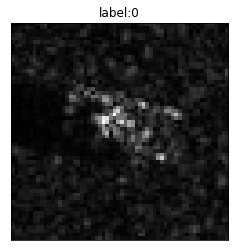

In [159]:
fig=plt.figure()
#plt.tight_layout()
plt.imshow(input_img.cpu().reshape(60,60),cmap='gray')
plt.title("{}:{}".format('label',train_label09[0].item()))
plt.xticks([])
plt.yticks([])
plt.savefig('example_of_60_60')
plt.show()

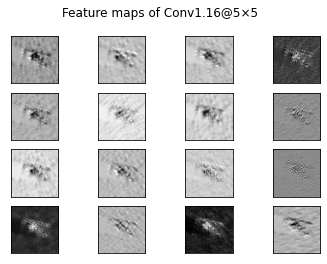

In [213]:
fig=plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(fmap_block0['output'][0][i].cpu().detach().numpy().reshape(56,56),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Feature maps of Conv1.16@5×5')
plt.savefig('60_60_conv1_feature')
plt.show()

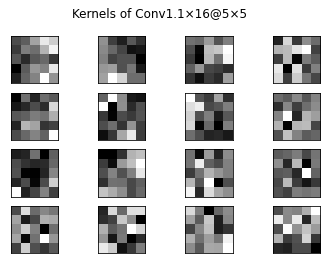

In [219]:
fig=plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(model.for_ward[0].weight[i].cpu().detach().numpy().reshape(5,5),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Kernels of Conv1.1×16@5×5')
plt.savefig('60_60_conv1_kernals')
plt.show()

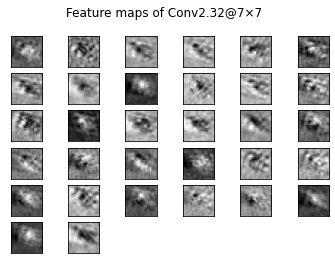

In [215]:
fig=plt.figure()
for i in range(32):
    plt.subplot(6,6,i+1)
    plt.imshow(fmap_block1['output'][0][i].cpu().detach().numpy().reshape(22,22),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Feature maps of Conv2.32@7×7')
plt.savefig('60_60_conv2_feature')
plt.show()

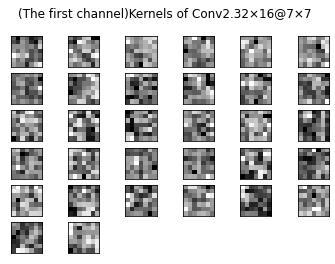

In [216]:
fig=plt.figure()
for i,j in enumerate(model.for_ward[4].weight[:,0,:,:]):
    plt.subplot(6,6,i+1)
    plt.imshow(j.cpu().detach().numpy().reshape(7,7),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('(The first channel)Kernels of Conv2.32×16@7×7')
plt.savefig('60_60_conv2_kernals')
plt.show()

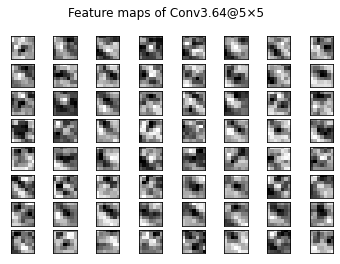

In [217]:
fig=plt.figure()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(fmap_block2['output'][0][i].cpu().detach().numpy().reshape(7,7),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Feature maps of Conv3.64@5×5')
plt.savefig('60_60_conv3_feature')
plt.show()

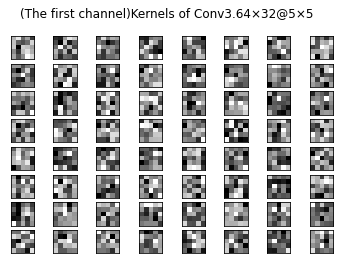

In [218]:
fig=plt.figure()
for i,j in enumerate(model.for_ward[9].weight[:,0,:,:]):
    plt.subplot(8,8,i+1)
    plt.imshow(j.cpu().detach().numpy().reshape(5,5),cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('(The first channel)Kernels of Conv3.64×32@5×5')
plt.savefig('60_60_conv3_keranals')
plt.show()